# ตั้งค่า และลงlibrary

## Install library

In [ ]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 20.0 MB/s 
     |████████████████████████████████| 346 kB 47.7 MB/s 
     |████████████████████████████████| 197 kB 64.2 MB/s 
     |████████████████████████████████| 4.2 MB 57.5 MB/s 
     |████████████████████████████████| 1.2 MB 65.3 MB/s 
     |████████████████████████████████| 59 kB 8.7 MB/s 
     |████████████████████████████████| 86 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 140 kB 24.0 MB/s 
     |████████████████████████████████| 212 kB 58.4 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 127 kB 62.3 MB/s 
     |████████████████████████████████| 144 kB 70.2 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
     |████████████████████████████████| 112 kB 63.9 MB/s 
     |████████████████

In [ ]:
from fastbook import *

# จัดการข้อมูลเพื่อใช้ในการเทรนโมเดล

## Split data

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

input_folder = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img_untraclean"

In [ ]:
#เปิดโฟล์เดอร์ที่ต้องการแบ่ง
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication


In [ ]:
splitfolders.ratio(input_folder, output="img_split", 
                   seed=42, ratio=(.85, .0, .15), 
                   group_prefix=None) 
#แบ่ง train val กับ test 0.85:0:0.15


Copying files: 0 files [00:00, ? files/s]
Copying files: 8 files [00:00, 66.46 files/s]
Copying files: 23 files [00:00, 109.34 files/s]
Copying files: 35 files [00:00, 108.94 files/s]
Copying files: 47 files [00:00, 110.08 files/s]
Copying files: 60 files [00:00, 114.63 files/s]
Copying files: 72 files [00:00, 114.63 files/s]
Copying files: 84 files [00:00, 112.38 files/s]
Copying files: 98 files [00:00, 120.38 files/s]
Copying files: 111 files [00:01, 106.05 files/s]
Copying files: 123 files [00:01, 108.60 files/s]
Copying files: 135 files [00:01, 107.61 files/s]
Copying files: 148 files [00:01, 112.92 files/s]
Copying files: 160 files [00:01, 110.93 files/s]
Copying files: 172 files [00:01, 107.42 files/s]
Copying files: 184 files [00:01, 109.00 files/s]
Copying files: 197 files [00:01, 114.14 files/s]
Copying files: 209 files [00:01, 114.40 files/s]
Copying files: 221 files [00:02, 109.65 files/s]
Copying files: 233 files [00:03, 23.07 files/s] 
Copying files: 241 files [00:03, 27.

## Prepare Dataloders

In [ ]:
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
)

In [ ]:
#ตำแหน่งของไฟล์ที่จะเทรน
PathTrain = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img_split/train"

In [ ]:
#ทำdataloader
dls = fields.dataloaders(PathTrain)

In [ ]:
#label
dls.vocab

['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']

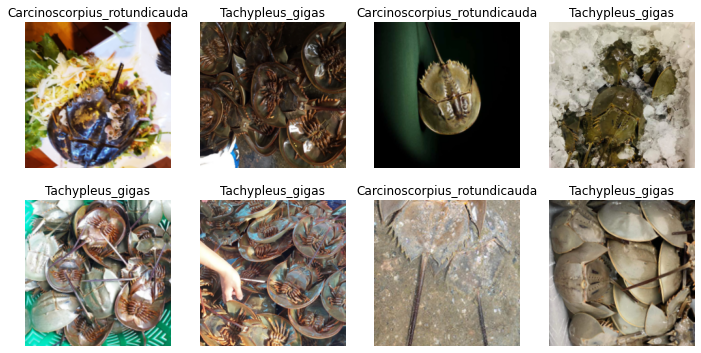

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

# **เทรน model**
ในที่นี้ผมใช้ backbone 5 อย่าง คือ 
1. VGG16
2. resneXt50
2. densenet201
3. VGG19
4. Squeezenet1_1
5. alexnet

## VGG16

In [ ]:
#load backbone
learner_VGG16 = cnn_learner(dls, models.vgg16_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

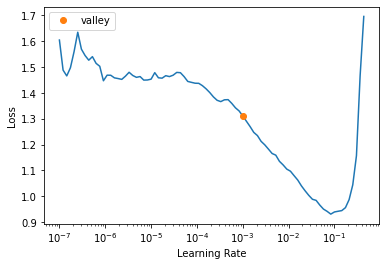

In [ ]:
# หา learning rate ที่เหมาะสม
learner_VGG16.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_VGG16.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0010000000474974513)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.478661,0.652930,0.328947,0.671053,0.647887,0.676471,0.621622,00:16


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.984251,0.645957,0.328947,0.671053,0.647887,0.676471,0.621622,00:14
1,0.986085,0.654389,0.355263,0.644737,0.584615,0.678571,0.513514,00:14
2,0.974828,0.671585,0.328947,0.671053,0.615385,0.714286,0.540541,00:14
3,0.956122,0.653145,0.302632,0.697368,0.656716,0.733333,0.594595,00:14
4,0.896684,0.593583,0.263158,0.736842,0.722222,0.742857,0.702703,00:14
5,0.847618,0.563125,0.289474,0.710526,0.694444,0.714286,0.675676,00:14
6,0.803739,0.562308,0.276316,0.723684,0.712329,0.722222,0.702703,00:15
7,0.772504,0.564472,0.276316,0.723684,0.712329,0.722222,0.702703,00:15
8,0.717352,0.569275,0.276316,0.723684,0.712329,0.722222,0.702703,00:14
9,0.662742,0.577119,0.263158,0.736842,0.722222,0.742857,0.702703,00:15


In [ ]:
#open path 
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4
learner_VGG16.export("VGG16_fastai.pkl")

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4


## resnext50

In [ ]:
from torchvision.models.resnet import resnext50_32x4d
#load backbone
learner_resnext = cnn_learner(dls, resnext50_32x4d, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

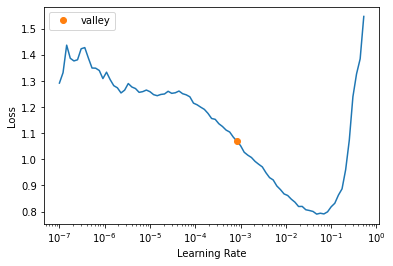

In [ ]:
learner_resnext.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_resnext.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.280635,0.683015,0.342105,0.657895,0.704545,0.607843,0.837838,01:18


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,0.867541,0.556316,0.236842,0.763158,0.775000,0.720930,0.837838,00:12
1,0.764053,0.518024,0.223684,0.776316,0.779221,0.750000,0.810811,00:12


KeyboardInterrupt: ignored

In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4


In [ ]:
learner_resnext.export("resnext50_fastai.pkl")

## densenet201

In [ ]:
learner_Den = vision_learner(dls, models.densenet201, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

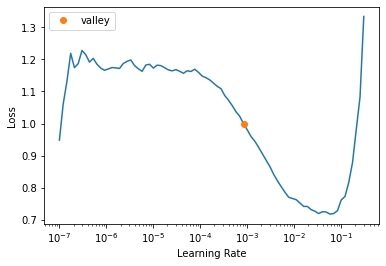

In [ ]:
learner_Den.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_Den.fine_tune(epochs=20,  freeze_epochs=1, base_lr =0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.410577,1.026947,0.421053,0.578947,0.686275,0.538462,0.945946,00:42


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.083549,0.720682,0.394737,0.605263,0.642857,0.574468,0.729730,00:13
1,0.906236,0.678046,0.368421,0.631579,0.650000,0.604651,0.702703,00:11
2,0.845519,0.678072,0.355263,0.644737,0.640000,0.631579,0.648649,00:11
3,0.754244,0.644326,0.263158,0.736842,0.729730,0.729730,0.729730,00:11
4,0.689042,0.660872,0.276316,0.723684,0.727273,0.700000,0.756757,00:11
5,0.634278,0.655309,0.236842,0.763158,0.756757,0.756757,0.756757,00:11
6,0.587892,0.654109,0.250000,0.750000,0.746667,0.736842,0.756757,00:11
7,0.529699,0.665390,0.236842,0.763158,0.756757,0.756757,0.756757,00:11
8,0.483576,0.693342,0.250000,0.750000,0.739726,0.750000,0.729730,00:11
9,0.433568,0.714695,0.236842,0.763158,0.750000,0.771429,0.729730,00:11


In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4


In [ ]:
learner_Den.export("densenet201_fastai.pkl")

## VGG19

In [ ]:
learner_VGG19 = cnn_learner(dls, models.vgg19_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

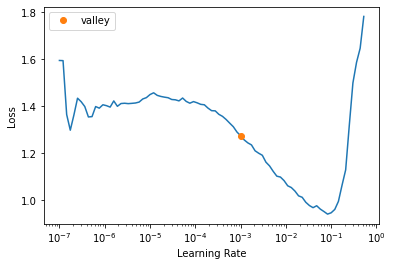

In [ ]:
learner_VGG19.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_VGG19.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0010000000474974513)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.501247,0.904272,0.565789,0.434211,0.527473,0.444444,0.648649,00:13


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.208502,0.938325,0.513158,0.486842,0.597938,0.483333,0.783784,00:17
1,1.051579,0.913367,0.447368,0.552632,0.645833,0.525424,0.837838,00:18
2,0.980409,0.871722,0.421053,0.578947,0.673469,0.540984,0.891892,00:17
3,0.931185,0.815391,0.394737,0.605263,0.687500,0.559322,0.891892,00:17
4,0.894118,0.787282,0.368421,0.631579,0.695652,0.581818,0.864865,00:17
5,0.815919,0.778682,0.328947,0.671053,0.731183,0.607143,0.918919,00:17
6,0.775483,0.725308,0.315789,0.684211,0.733333,0.622642,0.891892,00:17
7,0.726524,0.718379,0.263158,0.736842,0.772727,0.666667,0.918919,00:17
8,0.667744,0.730423,0.223684,0.776316,0.800000,0.708333,0.918919,00:18
9,0.622313,0.715861,0.210526,0.789474,0.809524,0.723404,0.918919,00:17


In [ ]:
learner_VGG19.export("VGG19_fastai.pkl")

## alexnet

In [ ]:
learner_Alex = cnn_learner(dls, alexnet, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

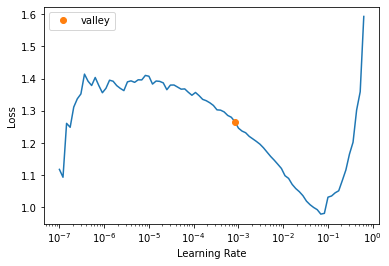

In [ ]:
learner_Alex.lr_find()

In [ ]:
learner_Alex.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.186039,3.039520,0.513158,0.486842,0.654867,0.486842,1.000000,00:09


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.168804,1.693388,0.500000,0.500000,0.654545,0.493151,0.972973,00:09
1,1.099376,1.118381,0.407895,0.592105,0.693069,0.546875,0.945946,00:09
2,1.061057,0.834611,0.328947,0.671053,0.719101,0.615385,0.864865,00:09
3,1.017794,0.705444,0.302632,0.697368,0.722892,0.652174,0.810811,00:09
4,1.008945,0.640075,0.289474,0.710526,0.738095,0.659574,0.837838,00:09
5,0.954604,0.618372,0.250000,0.750000,0.765432,0.704545,0.837838,00:09
6,0.907890,0.617664,0.276316,0.723684,0.740741,0.681818,0.810811,00:09
7,0.876286,0.607179,0.263158,0.736842,0.750000,0.697674,0.810811,00:09
8,0.840170,0.606966,0.250000,0.750000,0.765432,0.704545,0.837838,00:09
9,0.818428,0.592011,0.250000,0.750000,0.759494,0.714286,0.810811,00:09


In [ ]:
learner_Alex.export("alex_fastai.pkl")

# **โหลดโมเดลเพื่อทำนายผล**

## โหลดโมเดลจากที่เซฟไว้

In [ ]:
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

learn_inf = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/models4/resnext50_fastai.pkl')

In [ ]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(valid_name='test'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(224,224)
    )

In [ ]:
PathTest = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img_split"
test_dls = test_dblock.dataloaders(PathTest, bs=32)

## สร้าง confusion matrices

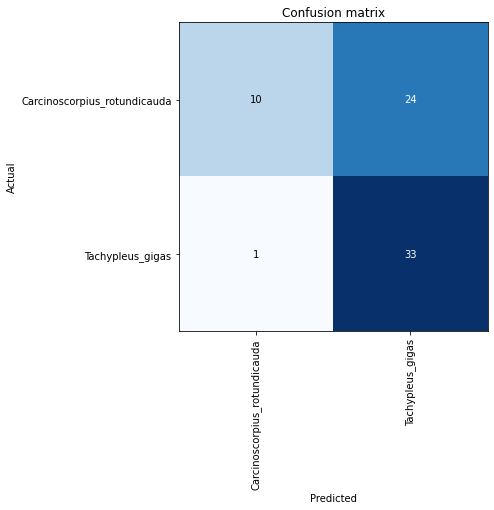

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_inf, dl=test_dls[1])
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
interp.print_classification_report()

                              precision    recall  f1-score   support

Carcinoscorpius_rotundicauda       0.91      0.29      0.44        34
            Tachypleus_gigas       0.58      0.97      0.73        34

                    accuracy                           0.63        68
                   macro avg       0.74      0.63      0.58        68
                weighted avg       0.74      0.63      0.58        68



In [ ]:
interp.most_confused(min_val=5)

[('Carcinoscorpius_rotundicauda', 'Tachypleus_gigas', 24)]

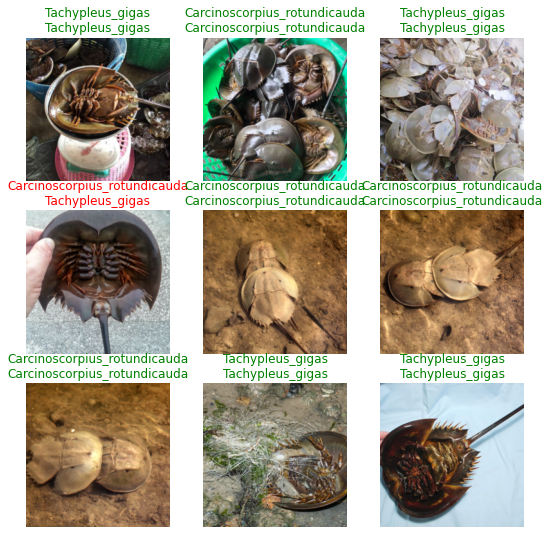

In [ ]:
interp.show_results(shuffle=True)